## Google Colab Setup

In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Imports and Data Cleaning

Credits @ [Chirag Samal](https://www.kaggle.com/chirag9073) from Kaggle for parts of the Data Cleaning code.

Link to the Kernel : [Zomato Restaurants Analysis and Prediction](https://www.kaggle.com/chirag9073/zomato-restaurants-analysis-and-prediction)

In [3]:
import seaborn as sns
from fastai.tabular import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
path = Path(base_dir+'zomato_bangalore_dataset')

In [5]:
zomato =pd.read_csv(path/'zomato.csv')

In [6]:
zomato.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [7]:
zomato.drop(['url',  'phone', 'dish_liked'], axis=1, inplace = True)

In [8]:
zomato.drop_duplicates(inplace=True)   # Removes rows with duplicate values as its columns
zomato.dropna(how='any',inplace=True)   #Drop rows with any of its columns as NA

In [9]:
zomato.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type', 'listed_in(city)':'city'}, inplace = True)

Removing the commas from the cost value (e.g.) 1,000 to 1000

In [10]:
zomato['cost'] = zomato['cost'].astype(str)
zomato['cost'] = zomato['cost'].apply(lambda x: x.replace(',','')) 
zomato['cost'] = zomato['cost'].astype(float)

Removing the /5 part from the ratings

In [11]:
zomato = zomato.loc[zomato.rate !='NEW']
zomato = zomato.loc[zomato.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato.rate = zomato.rate.apply(remove_slash).str.strip().astype('float')

Encoding the categorical variables

In [12]:
def Encode(zomato):
    for column in zomato.columns[~zomato.columns.isin(['rate', 'cost', 'votes'])]:
        zomato[column] = zomato[column].factorize()[0]
    return zomato

zomato_en = Encode(zomato.copy())

In [13]:
zomato_en.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,0,0,0,0,4.1,775,0,0,0,800.0,0,0,0,0
1,1,1,0,1,4.1,787,0,0,1,800.0,1,0,0,0
2,2,2,0,1,3.8,918,0,1,2,800.0,2,0,0,0
3,3,3,1,1,3.7,88,0,2,3,300.0,3,0,0,0
4,4,4,1,1,3.8,166,1,0,4,600.0,4,0,0,0


## Understanding the correlation between the input variables

In [14]:
corr = zomato_en.corr(method='kendall')   # Getting correlation between the input variables
corr_rate_sorted = corr.sort_values(by = ["rate"], ascending=False, inplace=False, kind='quicksort', na_position='last')   # Sorting  variables in "rate" column according to their correlation to the "rate" variable

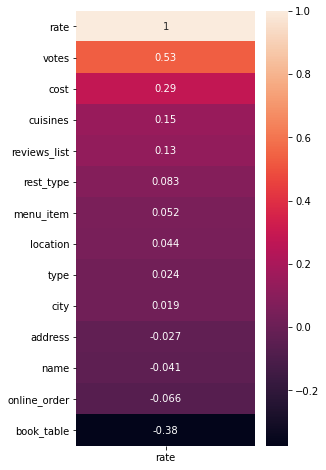

In [15]:
plt.figure(figsize=(4,8))
sns.heatmap(corr_rate_sorted[["rate"]], annot=True);

Picking the variables that have high correlation to the "rate" variable

In [16]:
dep_var = "rate"
cat_names = ["cuisines",  "reviews_list", "location"]
cont_names = ["votes", "cost"]
procs = [FillMissing, Categorify, Normalize]   

In [17]:
len(zomato)

41237

 ## Creating the DataBunch

In [18]:
np.random.seed(42)  

In [19]:
data = (TabularList.from_df(zomato, path = path, cat_names = cat_names, cont_names = cont_names, procs= procs)
                .split_by_rand_pct(valid_pct = 0.1)
                .label_from_df(cols = dep_var, label_cls=FloatList)
                .databunch())

In [20]:
data.show_batch(rows=10)

In [21]:
y_range = torch.tensor([0, 6], device=defaults.device)   
y_range

tensor([0, 6], device='cuda:0')

## Creating the Model and Training

In [22]:
learn = tabular_learner(data, layers=[200, 100], y_range = y_range, ps=[0.001, 0.01], emb_drop=0.04,  metrics=[rmse, r2_score])

In [23]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2348, 124)
    (1): Embedding(19727, 407)
    (2): Embedding(93, 20)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=553, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 2.09E-02


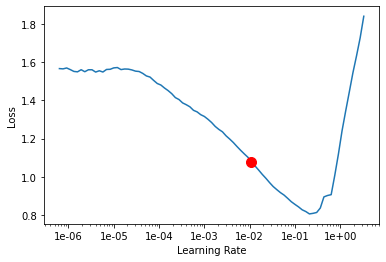

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion =True)

In [25]:
learn.fit_one_cycle(3, 3e-03, wd = 0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,0.073057,0.066819,0.255991,0.653266,00:05
1,0.034290,0.041014,0.200589,0.782411,00:05
2,0.014875,0.030977,0.172812,0.837148,00:04


epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


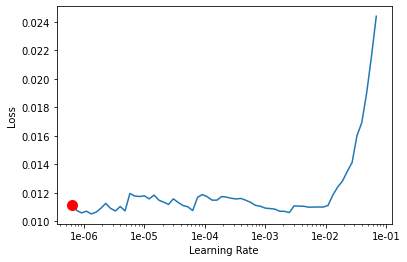

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion =True)

In [27]:
learn.fit_one_cycle(4, 5E-04, wd = 0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,0.012470,0.034428,0.181931,0.820016,00:05
1,0.009709,0.031539,0.173299,0.834781,00:05
2,0.007804,0.030855,0.171246,0.838436,00:04
3,0.006481,0.029127,0.166276,0.847448,00:05


epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 6.31E-08


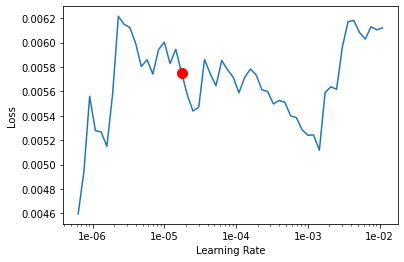

In [28]:
learn.lr_find()
learn.recorder.plot(suggestion =True)

In [29]:
learn.fit_one_cycle(2, 1E-06, wd = 0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,0.005535,0.028165,0.163701,0.852146,00:05
1,0.005201,0.028296,0.164069,0.851550,00:05


In [30]:
learn.save('final_zomato_model')

## Finding the r2_score and rmse for the model

In [31]:
learn.load('final_zomato_model')

Learner(data=TabularDataBunch;

Train: LabelList (37114 items)
x: TabularList
cuisines North Indian, Mughlai, Chinese; reviews_list [('Rated 4.0', 'RATED\n  A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only limited items available. But the taste and service was not compromised at all.The only complaint is that the breads could have been better.Would surely like to come here again.'), ('Rated 4.0', 'RATED\n  I was here for dinner with my family on a weekday. The restaurant was completely empty. Ambience is good with some good old hindi music. Seating arrangement are good too. We ordered masala papad, panner and baby corn starters, lemon and corrionder soup, butter roti, olive and chilli paratha. Food was fresh and good, service is good too. Good for family hangout.\nCheers'), ('Rated 2.0', 'RATED\n  Its a restaurant near to Banashankari BDA. Me along with few of my of

In [32]:
pred,y = learn.get_preds()
print("r2_score is : ", r2_score(pred, y))
print("rmse is : ", rmse(pred, y))

r2_score is :  tensor(0.8542)
rmse is :  tensor(0.1682)


So our model hits an r2_score of 85.42 and rmse of 16.82


In [33]:
learn.show_results() #taking a look at our predictions for few examples

cuisines,reviews_list,location,votes,cost,target,prediction
"North Indian, Chinese",#na#,Electronic City,-0.3477,-0.2225,3.7,[3.240173]
"Cafe, Beverages","[('Rated 4.0', ""RATED\n The ambience of the place is really cozy and nice, even though it's a small place. The waffles are really affordable and tasty. Worth a visit.""), ('Rated 2.0', ""RATED\n Been here twice. It's right next to where I live and the food is cheap.\nThe quality of the food is not great.\nThe service though, is extremely slow.\nWe had gone the first time as soon it opened. We were the only customer but still got the food 30 mins after we ordered and one of the dishes was omlette.\nIt's a nice place, if the service improves, I may recommend you to try it."")]",BTM,-0.3432,-0.6548,3.7,[3.727428]
Chinese,"[('Rated 2.0', 'RATED\n Heartbreaking to see good places make a mess of themselves. Have been visiting this place for several years now. Used to be good and crowded.\nToday there is nothing much to say. Place is falling apart. Cutlery is soiled and no one cares to clean it.\n\nHad manchow soup. It came with crispy noodles and one could only taste aata noodles. Apparently chef doesnÃ\x83Ã\x83Ã\x82Ã\x82Ã\x83Ã\x82Ã\x82Ã\x92t know a thing about balance.\nThere was no crisp in their crispy vegetables. Had to leave the meal mid way and spoil entire evening.\nWhat is wrong with you guys?\nGet some decent staff on board and pull up your socks guys.')]",HSR,0.0946,0.8583,2.4,[2.32248]
"North Indian, Chinese","[('Rated 3.0', 'RATED\n Late Night has become my go-to spot for comfort food. Although the quality has varied but I have enjoyed the food from the outlet every single time. Most often I would go for a serving of Chicken Chilli Garlic Fried Rice or Chicken Chilli Garlic Noodles along with a side-serving of Chicken in Hot Sauce. The North Indian section of the menu is also something one can try out. Particularly the Chicken Tikka Masala they offer.\n\nLate Night offers food which are slightly pricey but they are full of comfort none the less.'), ('Rated 3.0', 'RATED\n Hands down the best late night food in the area\nGobi manchurian- absolutely love, perfectly fried with taste\nSweets- Gulab Jamun, Gajar ka halwa,Randi\nAll could have been better\nThe delivery time is too long,took almost an hour')]",Kumaraswamy Layout,-0.0742,-0.2225,3.7,[3.706069]
Desserts,#na#,Brigade Road,-0.2937,-0.6548,4.0,[3.890959]


Exporting the model as a pickle file

In [34]:
learn.export(file = "export_preds_zomato.pkl")

## Testing the model on new data

Our goal is to predict the rating a restaurant is likely to get 

In [35]:
learn = load_learner(path, "export_preds_zomato.pkl") #loading the model for inference 

In [36]:
column_names = ['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city']

In [183]:
test_zomato = pd.DataFrame(columns= column_names)

We give values for the input variables

In [184]:
cuisines = "North Indian, Momos, Mughlai, Beverages"
location = "BTM"
cost = 550

Becuase newly opened restaurants have no votes, we then use correlation map to find the value with highest correlation to the variable "votes"

In [185]:
corr = zomato_en.corr(method='kendall')   # Getting correlation between the input variables
corr_rate_sorted = corr.sort_values(by = ["votes"], ascending=False, inplace=False, kind='quicksort', na_position='last')   # Sorting  variables in "rate" column according to their correlation to the "rate" variable

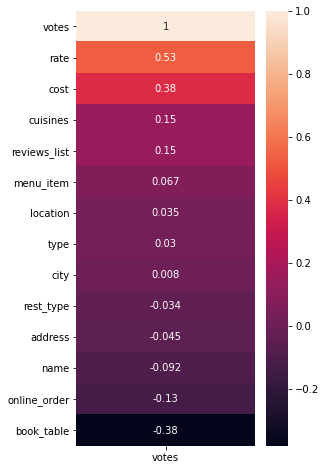

In [186]:
plt.figure(figsize=(4,8))
sns.heatmap(corr_rate_sorted[["votes"]], annot=True);

Turns out that "rate" has the highest correlation. But since that's value we want to predict, we go with "cost"

We then make find the average votes got by restaurants that serve in the same cost range.

In [187]:
cost_range_low = max(cost - 200, 0)
cost_range_high = cost+200

In [191]:
votes = zomato.loc[(zomato['cost'] >= cost_range_low) & ( zomato['cost'] <=cost_range_high) , 'votes'].mean()

In [192]:
votes

242.76824865260843

In [193]:
test_df = pd.DataFrame({"cuisines": [cuisines], "location": [location], "votes": [votes], "cost": [cost]})

In [194]:
test_zomato = test_zomato.append(test_df, ignore_index= True)

In [195]:
test_zomato

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,NaN,NaN,NaN,NaN,NaN,242.768249,BTM,NaN,"North Indian, Momos, Mughlai, Beverages",550,NaN,NaN,NaN,NaN


In [196]:
learn.predict(test_zomato.iloc[0])

(FloatItem [3.787604], tensor([3.7876]), tensor([3.7876]))

The restaurant is likely to get a rating of 3.79

## Doing PCA on Weights

In [44]:
zomato_w = learn.model.embeds[2].weight   # Getting the embedding weight matrix for the "location" variable
zomato_w.shape

torch.Size([93, 20])

In [45]:
zomato_pca = zomato_w.pca(3)   # Reducing the dimension of weights from 20 to 3
zomato_pca.shape

torch.Size([93, 3])

In [46]:
g = zomato.groupby("location")["rate"].count()
top_locations = g.sort_values(ascending=False).index.values[:50]
top_locations[:10]

array(['BTM', 'Koramangala 5th Block', 'HSR', 'Indiranagar', 'JP Nagar', 'Jayanagar', 'Whitefield', 'Marathahalli',
       'Bannerghatta Road', 'Koramangala 7th Block'], dtype=object)

In [47]:
fac0,fac1,fac2 = zomato_pca.t()   # Getting the individual factors

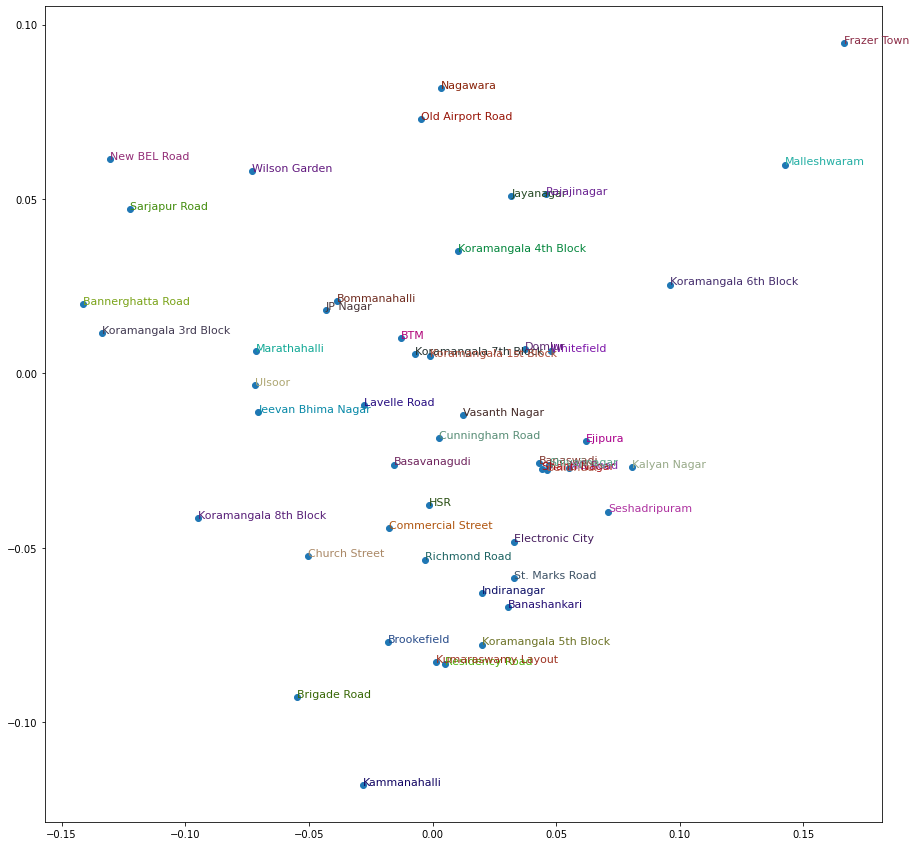

In [52]:
idxs = list(range(50))
X = fac1[idxs].cpu().detach().numpy()
Y = fac2[idxs].cpu().detach().numpy()
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_locations[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()